# Medical Insurance Cost Analysis
# Problem Statement
- The goal is to predict medical insurance charges in order to understand key cost drivers and estimate expected costs for individuals. This can support insurance pricing and risk assessment decisions based on demographic and health-related factors.

# Notes
- I will compute both MAE and RMSE, but prioritize RMSE because large prediction errors are particularly costly in insurance pricing, and RMSE penalizes those errors more strongly than MAE.

# Core Assumptions
### 1. Linearity
- Features have a roughly linear relationship with charges

### 2. Additivity
- Effects of features add together independently(e.g., smoking adds cost regardless of age, BMI, etc.)

### 3. Independence of observations
- Each individual is treated as independent
- No repeated individuals or household clustering

### 4. Homoscedasticity (constant variance)
- Prediction errors have similar spread across cost levels(This is often violated in insurance data)

### 5. No severe multicollinearity
- Predictors are not overly redundant(e.g., BMI and age aren’t perfectly correlated)

In [1]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
df= pd.read_csv("insurance.csv")
print("Shape:", df.shape)
df.head()

Shape: (1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [4]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

# Exploratory Data Analysis

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [6]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


- Insurance costs are highly skewed(mean>median). This indicates that a small group of individuals incur very large expenses.
- Age is widespread (18-64) with a mean of 39.
- Average BMI is 30.7 indicating that the average individual is overweight/obese.
- Children have a low variance since most have 0-2 with outliers of up to 5.
- **Takeaway:** Age and BMI have enough variability to explain cost differences. Children likely plays a minor role.

In [7]:
df["sex"].value_counts()

sex
male      676
female    662
Name: count, dtype: int64

In [8]:
df["smoker"].value_counts()

smoker
no     1064
yes     274
Name: count, dtype: int64

In [9]:
df["region"].value_counts()

region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64

Sex and region are evenly distributed representing a low likelihood of dominating predictions. On the other hand **smoker** stands out as the only categorical variable likely to have a large effect size.

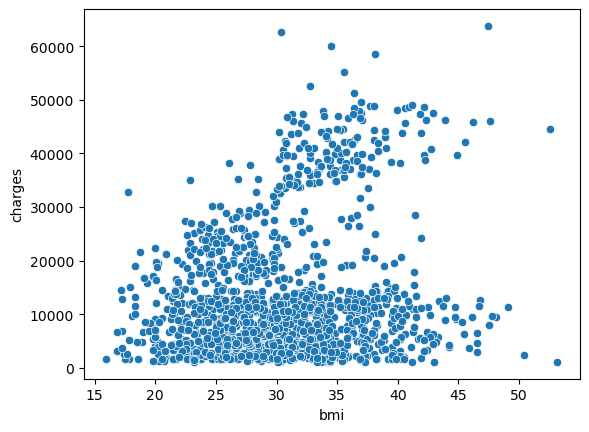

In [10]:
# BMI vs Charges
sns.scatterplot(x="bmi",y="charges",data=df)
plt.show()

- Weak upward trend
- Increasing spread at higher charges
- Two “bands” visible - hints at interaction (likely smoking)

**Interpretation:** BMI alone weakly increases costs, but its effect is amplified for certain subgroups. Linear regression will capture the average effect but miss interactions unless explicitly modeled.

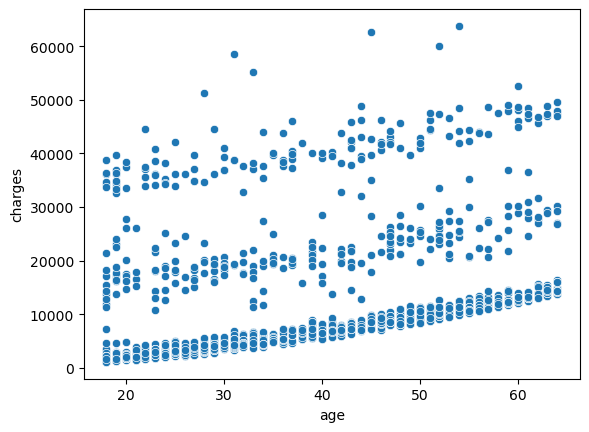

In [11]:
# Age vs Charges
sns.scatterplot(x="age",y="charges",data=df)
plt.show()

- Clear upward trend
- Parallel bands across age

**Interpretation:**
Age is a consistent cost driver. As people age, expected insurance costs increase in a fairly linear way. This is a strong signal for regression.

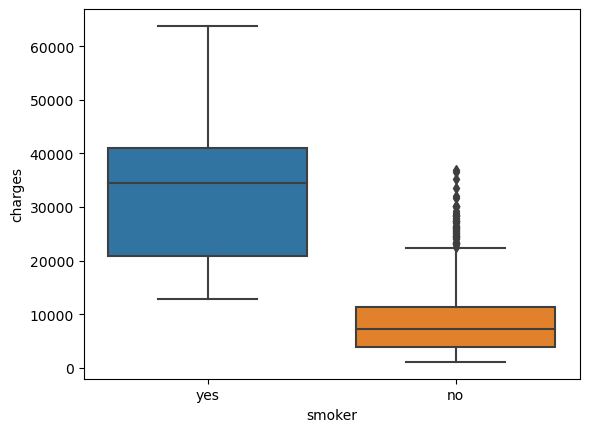

In [12]:
# Smoking vs Charges
sns.boxplot(x="smoker",y="charges",data=df)
plt.show()

- Smokers’ median and spread are dramatically higher
- Minimal overlap between smoker and non-smoker distributions

**Interpretation:**
Smoking is the single strongest predictor of insurance costs in this dataset. Any reasonable model must capture this effect.

In [13]:
# Correlation
df.corr(numeric_only=True)

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


- Age has the strongest linear association
- BMI has a modest relationship
- Children has very weak linear relationship

In [14]:
# Groupby
df.groupby("smoker")["charges"].mean()

smoker
no      8434.268298
yes    32050.231832
Name: charges, dtype: float64

On average, smokers incur nearly **4× higher** medical insurance costs than non-smokers. This dwarfs the effects of age, BMI or number of children.

From a business standpoint:
- Smoking status is a primary pricing driver
- Any insurance pricing model that ignores smoking is fundamentally flawed

## EDA Findings Summary
Insurance charges are highly right-skewed, with a small proportion of individuals incurring very high costs. Age and BMI show moderate positive relationships with charges, indicating that costs tend to increase as individuals age or gain weight. However, smoking status is the dominant cost driver, with smokers exhibiting substantially higher medical charges than non-smokers. These patterns suggest that linear regression is a reasonable baseline model, though large cost outliers and subgroup effects should be acknowledged as limitations.

## Limitations
The distribution of charges is highly skewed, and linear regression may struggle to accurately predict extreme high-cost cases.

# Model Training

In [16]:
# Defining dependent and independent variables
target= "charges"
X= df.drop(columns=[target])
y= df[target]

In [17]:
# Encoding sex, smoker and region because they are strings
X_encoded=pd.get_dummies(
    X,
    columns=["sex","smoker","region"],
    drop_first= True
)

In [18]:
X_encoded.head()

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,False,True,False,False,True
1,18,33.770,1,True,False,False,True,False
2,28,33.000,3,True,False,False,True,False
3,33,22.705,0,True,False,True,False,False
4,32,28.880,0,True,False,True,False,False


In [19]:
# Splitting training and testing data
X_train, X_test, y_train, y_test= train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [20]:
X_train.shape, X_test.shape

((1070, 8), (268, 8))

In [22]:
# Checking if data types are numeric
X_train.dtypes

age                   int64
bmi                 float64
children              int64
sex_male               bool
smoker_yes             bool
region_northwest       bool
region_southeast       bool
region_southwest       bool
dtype: object

# Model Development

In [23]:
# Initializing the model
lm= LinearRegression()

In [24]:
# Fit the model using the training data
lm.fit(X_train, y_train)

LinearRegression()

In [25]:
# Make predictions on the test data
y_pred= lm.predict(X_test)

In [26]:
y_pred[0:5]

array([ 8969.55027444,  7068.74744287, 36858.41091155,  9454.67850053,
       26973.17345656])

# Model Evaluation

In [28]:
# Evaluating the model
mae= mean_absolute_error(y_test, y_pred)
rmse= np.sqrt(mean_squared_error(y_test, y_pred))
r2= r2_score(y_test, y_pred)
print("MAE:",mae)
print("RMSE:",rmse)
print("r2:",r2)

MAE: 4181.194473753648
RMSE: 5796.284659276271
r2: 0.7835929767120724


## Interpretation
**MAE:** The model has an average absolute prediction error of approximately $4,200, meaning typical predictions deviate from actual charges by this amount.

**RMSE:** RMSE is notably higher than MAE, indicating that while average errors are moderate, the model struggles more with high-cost individuals, which is consistent with the right-skewed nature of medical insurance charges.

**R2:** The model explains approximately 78% of the variation in insurance charges, indicating a strong overall fit, though a meaningful portion of cost variability, particularly extreme cases, remains unexplained.

In [31]:
# Extracting coefficients
coefficients = pd.Series(
    lm.coef_,
    index=X_train.columns
).sort_values(ascending=False)

coefficients

smoker_yes          23651.128856
children              425.278784
bmi                   337.092552
age                   256.975706
sex_male              -18.591692
region_northwest     -370.677326
region_southeast     -657.864297
region_southwest     -809.799354
dtype: float64

# Coefficients Interpretation
**Smoker_yes:** Holding age, BMI, number of children, sex, and region constant, being a smoker is associated with an increase of approximately $23,651 in expected insurance charges.

**Children:** Each additional child covered by insurance is associated with an increase of approximately $425 in annual charges, holding other factors constant.

**BMI:** For each one-unit increase in BMI, expected insurance charges increase by roughly $337, all else equal.

**Age:** Each additional year of age is associated with an increase of approximately $257 in insurance charges, holding other factors constant.

**Sex_male:** After controlling for other variables, sex has a negligible effect on insurance charges in this model.

**Region:** Relative to the baseline region, individuals in other regions are associated with slightly lower expected charges, though these effects are modest compared to factors such as smoking status.

# Analyst Conclusion
The linear regression model demonstrates strong explanatory power, accounting for approximately 78% of the variation in medical insurance charges. Smoking status emerges as the dominant cost driver, increasing expected charges by over $23,000 on average, even after controlling for demographic and health-related factors. Age, BMI and number of children also contribute positively to costs but with a smaller effect. Despite the strong overall fit, the model exhibits higher errors for high-cost individuals, as reflected by the RMSE, highlighting limitations in predicting extreme medical expenses.

# Limitations
1. Skewed target variable- High-cost outliers inflate RMSE.

2. Linear assumptions- Nonlinear effects and interactions (e.g. BMI × smoker) are not captured.

3. Prediction vs pricing- This model supports understanding, not actuarial pricing decisions.

# Author
## Wanjiru Kamau